<img src = "https://www.tilburguniversity.edu/upload/c67b70dd-9a4f-499b-82e0-0aee20dfe12a_jads%20logo.png",width=500>

## Performance of Mobile Gaming Apps

* The Impact of a Business Model on the Relationship between Entrance Timing and Performance among Mobile Games

The goal of this notebook is to guide readers through the process of analyzing Apple AppStore data received from Tilburg University. For more information read through the attached paper that was created for the purpose of finishing the master course Strategy and Business Models. 

## <a name="table">Table of Contents</a> 
 
1. [Dataset](#dataset)
    
2. [Purpose of this Study](#goal)

3. [Functions](#functions) 

4. [Data Preparation](#dataprep)

    4.1 [Time Slots](#timeslots)
    
    4.2 [EDA](#eda)
    
    4.3 [Creating Final Variables](#variables)
    
    4.4 [Correlation Matrix](#correlation)

5. [Selecting Statistical Model](#selectingmodel)

6. [Statistical Analysis - Revenue Model](#revenue)

    6.1 [Main Effects](#revenuemain)
    
    6.2 [Interaction Effects](#revenueinteraction)
    
    6.3 [Truncated Model](#revenuetruncated)
    
    6.4 [Logistical Model](#revenuelogistical)
    
    6.5 [Results](#revenueresults)

7. [Statistical Analysis - Technological Innovation](#ti)

    7.1 [Main Effects](#timain)
    
    7.2 [Interaction Effects](#tiinteraction)
    
    7.3 [Truncated Model](#titruncated)
    
    7.4 [Logistical Model](#tilogistical)
    
    7.5 [Results](#tiresults)

8. [Conclusion](#conclusion) 

9. [References](#literature) 

### <a name="dataset">1. Dataset</a> 
[Back to Table of Contents](#table)

The dataset used in the study is information regarding apps scraped from the Apple AppStore. From those apps their category was collected, average rating, number of ratings, etc. For more details see "Data Preparation". 

### <a name="goal">2. Purpose of this study</a> 
[Back to Table of Contents](#table)

The main purpose of the study is to research the effects of a business model on the performance of Apple AppStore apps. Without going too much into the academic research, the following hypotheses were tested in this paper:  
  
* Hypothesis 1: Both early and late entrants will perform better when they make use of
the free revenue model compared to the paid revenue model

* Hypothesis 2: Order of entry and revenue model interact such that free apps will
perform better when they are late entrants versus early entrants, whereas paid apps will
perform better when they are early entrants versus late entrants.
  
* Hypothesis 3: Order of entry and technological innovation interact such that apps using
technological innovation will perform better when they are early entrants versus late
entrants, whereas apps not using technological innovation will perform better when they
are late entrants versus early entrants.

I start by cleaning the data and doing some exploratory data analysis (EDA) before doing the statistical analysis. I try to be as clear as possible during the process what is done and for which reason. It should be noted though that for details you might want to look in the paper that was written with my fellow students. Moreover, since I'm not able to share the data this notebook cannot be run on your system. This notebook is to show my thought process when doing the analysis. 

### <a name="functions">3. Functions</a> 
[Back to Table of Contents](#table)
Here are all the functions used in this study. It's a lot, I know! Normally this would all be in a separate .py file, but the goal is to be transparent, so here it is :-)

In [1]:
import re                 as re
import pandas             as pd
import matplotlib.pyplot  as plt
import numpy              as np
import seaborn            as sns

import string

from collections          import Counter
from nltk.corpus          import stopwords
from collections          import Counter

%matplotlib inline 
%load_ext rpy2.ipython

def create_4_timeslots(df):
    """ Creates and returns dataframes in 4 timeslots:
        - first_seen_2015: Apps in 2015 that were first seen around may
        - last_seen_2015: Apps in 2015 that were last seen around september
        - first_seen_2017: Apps in 2017 that were first seen around may
        - last_seen_2017: Apps in 2017 that were last seen around september
    """
    # Create a dataframe with apps in 2015 that were first seen around may
    first_seen_2015 = df[(df['timestamp'] == df['firstseen']) & (df['firstseen'].str.contains('2015'))].groupby(by='id').first()
    first_seen_2015 = first_seen_2015.reset_index()

    # Create a dataframe with apps in 2017 that were first seen around may
    first_seen_2017 = df[(df['timestamp'] == df['firstseen']) & (df['firstseen'].str.contains('2017'))].groupby(by='id').first()
    first_seen_2017 = first_seen_2017.reset_index()

    # Create dataframes with apps in 2015 and 2017 that were last seen around september
    last_seen_2015 = df[(df['week'] > 30) & (df['week'] < 40)].groupby(by='id').last().reset_index()
    last_seen_2017 = df[df['week'] > 90].groupby(by='id').last().reset_index()
    
    return first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017

def create_4_equal_timeslots(first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017):
    """ Returns the dataframes of the 4 timeslots so that they include the exact same apps.
        - first_seen_2015 and last_seen_2015 contain the same apps
        - first_seen_2017 and last_seen_2017 contain the same apps
    """
    # Making sure all id's that are in last_seen are also in first_seen
    list_ls_2015 = list(last_seen_2015['id'])
    first_seen_2015 = first_seen_2015[first_seen_2015['id'].isin(list_ls_2015)]

    # Making sure all id's that are in first_seen are also in last_seen
    list_fs_2015 = list(first_seen_2015['id'])
    last_seen_2015 = last_seen_2015[last_seen_2015['id'].isin(list_fs_2015)]

    # Making sure all id's that are in last_seen are also in first_seen
    list_ls_2017 = list(last_seen_2017['id'])
    first_seen_2017 = first_seen_2017[first_seen_2017['id'].isin(list_ls_2017)]

    # Making sure all id's that are in first_seen are also in last_seen
    list_fs_2017 = list(first_seen_2017['id'])
    last_seen_2017 = last_seen_2017[last_seen_2017['id'].isin(list_fs_2017)]
    
    return first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017

def create_common_words():
    """ Returns a dataframe that contains the most common words for apps found in 2015 and 2017. 
        I specifically choose to only include first seen apps seeing as that was their initial strategy. 
    """
    # Create stopwords and add some stopwords that I want removed
    stopwords_english = stopwords.words('english')

    for word in ['u2022', '', 'u2028', 'will', 'get', 'make', 'like', 'just', 'use', 'u2013', 'let', 'game', '\u2022', '-', '&', 
                'u', 'e', 'f', 'b', 'c', 'cu', 'bu', 'au', 'fu', 'us', 'go', 'du', 'eu', 'ea', 'uff', 'n', 'one']:
        stopwords_english.append(word)

    # Create descriptions for each year (first seen), clean it and count the number of words
    description = {'2017': '', '2015': ''}

    for year, value in description.items():
        description[year] = eval('first_seen_{}'.format(year))['description'].str.cat(sep=' ') # create one string of column
        description[year] = re.sub('[^a-zA-z]', ' ', description[year]) # only keep letters
        description[year] = description[year].replace("\\", "").lower() # remove backslashes and lower the text
        description[year] = ' '.join(description[year].split()) # Remove too many spaces
        description[year] = description[year].split(' ') # create a list with words
        description[year] = Counter(description[year]) # Count how often a word occurs

        # Removing stopwords
        for word in stopwords_english:
            if word in description[year].keys():
                del description[year][word]

    # Create a dataframe of the count of words for each year for easier readability
    df = pd.DataFrame()

    for year in ['2015', '2017']:
        for action, value in {'word': 0, 'count': 1}.items():
            df['{}_{}'.format(year, action)] = [word[value] for word in description[year].most_common(1000)]
            
    return df

def join_first_last(first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017):
    """ Returns the following two dataframes:
        - df_2015: An inner join of first_seen_2015 and last_seen_2015
        - df_2017: An inner join of first_seen_2015 and last_seen_2017
    """
    # Merges first_seen_2015 with last_seen_2015 and adds _first and _last to columns to show which belong to which data
    first_seen_2015.columns = [column + "_first" if column != 'id' else 'id' for column in first_seen_2015.columns]
    last_seen_2015.columns = [column + "_last" if column != 'id' else 'id' for column in last_seen_2015.columns]
    df_2015 = pd.merge(first_seen_2015, last_seen_2015, on='id')
    
    # Merges first_seen_2017 with last_seen_2017 and adds _first and _last to columns to show which belong to which data
    first_seen_2017.columns = [column + "_first" if column != 'id' else 'id' for column in first_seen_2017.columns]
    last_seen_2017.columns = [column + "_last" if column != 'id' else 'id' for column in last_seen_2017.columns]
    df_2017 = pd.merge(first_seen_2017, last_seen_2017, on='id')

    return df_2015, df_2017

def get_change(row, column_1, column_2):
    """ Used for lambda expression. Compares two columns and gives back a 1 if there's a difference and 0 if there isn't. 
    """
    if row[column_1] != row[column_2]:
        return 1
    else:
        return 0
    
def create_change_columns(df_2015, df_2017, columns = ['price', 'screenshots', 'content_rating', 'compatibility', 
                                                            'size', 'quan_language', 'appversion', 'ratingscurrentversion', 
                                                            'ratingcurrentversion', 'title']):
    """ This will return two dataframes that have a number of new columns that signify the differences between the
        value when firstseen and lastseen. For example, the 'price' column might change when first released and seen a
        half year later. This function will return dataframes with columns that show whether there was a change (1) or not (0).
    """
    for column in columns:
        df_2015['change_{}'.format(column)] = df_2015.apply(lambda row: get_change(row, '{}_first'.format(column), 
                                                                                        '{}_last'.format(column)), axis = 1)
        df_2017['change_{}'.format(column)] = df_2017.apply(lambda row: get_change(row, '{}_first'.format(column), 
                                                                                        '{}_last'.format(column)), axis = 1)
    return df_2015, df_2017

def show_changes(df_2015, df_2017, columns = ['price', 'screenshots', 'content_rating', 'compatibility', 'size', 
                                              'quan_language', 'appversion', 'ratingscurrentversion', 'ratingcurrentversion', 
                                              'title']):
    """ Prints the number of changes of a column between firstseen and lastseen for 2015 and 2017
    """
    for year in ['2015', '2017']:
        print('Changes in column between firstseen and lastseen of {}:\n'.format(year))

        for column in columns:
            changes = eval('df_{}'.format(year))['change_{}'.format(column)].value_counts()[1]

            if len(column) < 20:
                column = (' '*(20-len(column))) + column
            else:
                continue

            print('{}: \t{} of {}'.format(column, changes, len(eval('df_{}'.format(year)))))
        print()
        
def optimized_for(df_2015, df_2017, devices = ['iphone', 'ipad', 'ipod touch']):
    """ Prints how many of the apps are optimized for certain devices based on their release
    """
    print('Apps in 2015 that are optimized for the following devices (based on their release): \n')
    for value in devices:
        df_2015['optimized_for_{}'.format(value)] = df_2015.apply(lambda row: 1 if value in row['compatibility_first'].lower() 
                                                                  else 0, axis = 1)
        optimized = df_2015['optimized_for_{}'.format(value)].value_counts()[1]
        value = ' '*(20-len(value)) + value
        print('{}: \t {} out of {}'.format(value, optimized, len(df_2015)))
    print()
        
    print('Apps in 2017 that are optimized for the following devices (based on their release): \n')
    for value in devices:
        df_2017['optimized_for_{}'.format(value)] = df_2017.apply(lambda row: 1 if value in row['compatibility_first'].lower() 
                                                                  else 0, axis = 1)
        optimized = df_2017['optimized_for_{}'.format(value)].value_counts()[1]
        value = ' '*(20-len(value)) + value
        print('{}: \t {} out of {}'.format(value, optimized, len(df_2017)))
    print()
    
def count_subcategories(df_2015, df_2017):
    """ Prints how many apps there are in certain subcategories which are based on certain keywords in an apps description. 
    """
    slot_games = ['casino', 'slots', 'slot']
    driving = ['race', 'drive', 'car', 'driving', 'parking']
    puzzle = ['puzzle']
    adventure = ['adventure', 'jump', 'platformer']
    shooter = ['shoot', 'gun', 'pistol', 'sniper', 'war', 'vehicle']
    
    subcategories = {'slot_games': slot_games, 'driving': driving, 'puzzle': puzzle, 'adventure': adventure, 'shooter': shooter}
    
    print('Number of apps in 2015 in the following subcategories:\n')
    for category, search_terms in subcategories.items():
        amount = len(df_2015[df_2015['description_first'].str.contains('|'.join(search_terms))])
        
        category = " "*(20-len(category)) + category
        print(category, ': ', amount, '\tBased on the following terms: {}'.format(', '.join(search_terms)))
    print('          Total Apps :  {}'.format(len(df_2015)))
        
    print('\nNumber of apps in 2017 in the following subcategories:\n')
    for category, search_terms in subcategories.items():
        amount = len(df_2017[df_2017['description_first'].str.contains('|'.join(search_terms))])
        
        category = " "*(20-len(category)) + category
        print(category, ': ', amount, '\tBased on the following terms: {}'.format(', '.join(search_terms)))
    print('          Total Apps :  {}'.format(len(df_2017)))

def get_difference_rating(row1, row2):
    """ Returns the difference in rating between first seen and last seen. 
        If both first seen and last seen have a rating of -1, then it will return 0
        If only first seen has a rating of -1, then it will return the rating of last seen
        In all other cases it returns the difference between last seen and first seen
    """
    if row1 == -1:
        if row1 == row2:
            return 0
        else:
            return row2
    else:
        return row2 - row1
    
def return_difference_rating(df_2015, df_2017):
    """ Calculates the difference between the rating(s) of an app when it was last seen and when it was first seen.
        Returns two dataframes with each two extra column indicating the difference in rating(s).
    """
    df_2015['difference_rating'] = df_2015.apply(lambda row: get_difference_rating(row['ratingcurrentversion_first'],
                                                                                   row['ratingcurrentversion_last']), axis = 1)
    df_2017['difference_rating'] = df_2017.apply(lambda row: get_difference_rating(row['ratingcurrentversion_first'],
                                                                                   row['ratingcurrentversion_last']), axis = 1)
    df_2015['difference_ratings'] = df_2015.apply(lambda row: get_difference_rating(row['ratingscurrentversion_first'],
                                                                                   row['ratingscurrentversion_last']), axis = 1)
    df_2017['difference_ratings'] = df_2017.apply(lambda row: get_difference_rating(row['ratingscurrentversion_first'],
                                                                                   row['ratingscurrentversion_last']), axis = 1)
    return df_2015, df_2017

def get_revenue_model(row):
    """ Returns whether an app if freemium or paid
    """
    if row['price_first'] == 0:
        return 'Freemium'
    else:
        return 'Paid'
    
def get_subcategory(row):
    """ Get subcategory based on the amount of keywords are present in the description
    """
    slot_games = ['casino', 'slots', 'slot']
    driving = ['race', 'drive', 'car', 'driving', 'parking', 'park', 'racing', 'match 3', 'match three', 'match four', 'clues']
    puzzle = ['puzzle', 'puzzles', 'puzzling']
    adventure = ['adventure', 'jump', 'platformer']
    shooter = ['shoot', 'gun', 'pistol', 'sniper', 'war', 'vehicle']
    
    
    subcategories = {'slot_games': slot_games, 'driving': driving, 'puzzle': puzzle, 'adventure': adventure, 'shooter': shooter,
                    'matching': matching}
    count_categories = {'slot_games': 0, 'driving': 0, 'puzzle': 0, 'adventure': 0, 'shooter': 0, 'matching': 0}
    
    
    description = row['description_first']
    description = re.sub('[^a-zA-z]', ' ', description) # only keep letters
    description = description.replace("\\", "").lower() # remove backslashes and lower the text
    description = ' '.join(description.split()) # Remove too many spaces
    description = description.split(' ') # create a list with words
    description = Counter(description) # Count how often a word occurs
        
    # Count how many times a certain keyword in one of the categories is seen in a description
    for category in subcategories:
        for word in subcategories[category]:
            if word in description.keys():
                count_categories[category] += description[word]
    
    # The category with the most words is returned
    if Counter(count_categories).most_common(1)[0][1] == 0:
        return 'Other'
    elif Counter(count_categories).most_common(1)[0][1] == Counter(count_categories).most_common(2)[1][1]:
        return 'Other'
    else:
        return Counter(count_categories).most_common(1)[0][0]  
    

def create_subcategory(row):
    """ Get subcategory based on keywords being present in the description
    """
    slot_games = ['casino', 'slots', 'slot']
    driving = ['race', 'drive', 'car', 'driving', 'parking', 'park', 'racing']
    puzzle = ['puzzle', 'puzzles', 'puzzling', 'match 3', 'match three', 'match four', 'clues']
    adventure = ['adventure', 'jump', 'platformer']
    shooter = ['shoot', 'gun', 'pistol', 'sniper', 'war', 'vehicle']

    description = row['description_first']
    description = re.sub('[^a-zA-z]', ' ', description) # only keep letters
    description = description.replace("\\", "").lower() # remove backslashes and lower the text
    description = ' '.join(description.split()) # Remove too many spaces
    description = description.split(' ') # create a list with words
    
    categories = {'slot_game': slot_games, 'driving': driving, 'puzzle':puzzle, 'adventure': adventure, 'shooter': shooter}
    
    for name, category in categories.items():
        counter = 0
        for word in category:
            if (word in description) & (counter == 0):
                row[name] = 1
                counter += 1
                break
            else:
                continue
        if counter == 0:
            row[name] = 0
    return row
             
def get_ios_version(row):
    return row['compatibility_first'].split('iOS')[1].strip().split(' ')[0].strip().split('.')[0]

def get_content_rating(row):
    """ Return the minimum age for a game
    """
    rating = row['content_rating_first'].split(" ")[0].replace('+', ' ')
    rating = row['content_rating_first'].split('+')[0]
    
    try:
        rating = int(rating)
        return rating
    except:
        rating = re.sub('[^0-9]','', row['content_rating_first'])
        
        try:
            if int(rating) > 20:
                print(row['content_rating_first'])
            return int(rating)
        except:
            'Error'

def create_variables(df_2015, df_2017):
    # Create early vs. late mover columns
    df_2015['mover'] = 'early'
    df_2017['mover'] = 'late'

    # Get revenue model
    df_2015['revenue'] = df_2015.apply(lambda row: get_revenue_model(row), axis = 1)
    df_2017['revenue'] = df_2017.apply(lambda row: get_revenue_model(row), axis = 1)

    # Get the subcategory
    df_2015 = df_2015.apply(lambda row: create_subcategory(row), axis = 1)
    df_2017 = df_2017.apply(lambda row: create_subcategory(row), axis = 1)

    # Get optimized for ipod touch
    df_2015['optimized_ipod_touch'] = df_2015.apply(lambda row:1 if 'ipod touch' in row['compatibility_first'].lower() 
                                                    else 0,axis=1)
    df_2017['optimized_ipod_touch'] = df_2017.apply(lambda row:1 if 'ipod touch' in row['compatibility_first'].lower() 
                                                    else 0,axis=1)

    # Get the lowest version of iOS for which the app will work
    df_2015['ios_version'] = df_2015.apply(lambda row: get_ios_version(row), axis = 1)
    df_2017['ios_version'] = df_2017.apply(lambda row: get_ios_version(row), axis = 1)

    # content rating
    df_2015['content_rating'] = df_2015.apply(lambda row: get_content_rating(row), axis = 1)
    df_2017['content_rating'] = df_2017.apply(lambda row: get_content_rating(row), axis = 1)
    
    return df_2015, df_2017

def show_correlation_matrix(df):
    sns.set(style="white")
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
    
def get_innovation(row):
    # Technological Innovation (TI)
    innovation = ['gyroscope', 'accelerometer', 'vr', 'ar', 'a.r', 'vr-', 'iamcardboard', 
                'fibrum', 'homido', 'zeiss', 'beenoculus', 'colorcross', 'airvr', 'gyrometer', 'prodji', 'advanceddji',
                 'prodroneprix', 'onelick', 'vrarchos', 'vrdive', 'vrfreefly', 'gamepad', 'bluetooth']
    
    description = row['description_first']
    description = re.sub('[^a-zA-z]', ' ', description) # only keep letters
    description = description.replace("\\", " ").lower() # remove backslashes and lower the text
    description = ' '.join(description.split()) # Remove too many spaces
    description = description.split(' ') # create a list with words
    
    row['innovation'] = 0
    for word in innovation:
        for word_2 in description:
            if word == word_2:
                row['innovation'] = 1
    
    description = re.sub('[^a-zA-z]', ' ', row['description_first']).lower().replace('\\', '')
    terms = ['augmented reality', 'virtual reality', 'motion control', 'tilt the device', 'tilting the device',
             'google cardboard', 'vr-', 'facing camera', 'tilt your device', 'camera lens', 'tilt your head',
             'gyro sensor', 'game pad', 'rotate lens', 'wear your glasses']
    for term in terms:
        if term in description:
            row['innovation'] = 1
    if ('vr-' in row['description_first'].lower().replace('\\', '')):
        row['innovation'] = 1
    if ('ar-' in row['description_first'].lower().replace('\\', '')):
        row['innovation'] = 1
        
    return row

### <a name="dataprep">4. Data Preparation</a> 
[Back to Table of Contents](#table)

The dataset app_details contain information regarding all apps in the Apple AppStore in the last 3 years. 

In [2]:
df = pd.read_csv('Data set/app_details.csv', low_memory=False)

#### <a name="timeslots">4.1 Time Slots</a> 
[Back to Table of Contents](#table)

I want to see the difference in performance between early and late movers after five months of being released. Therefore, four timeslots needs to be created:  
- Apps first seen in 2015 (i.e., first_seen_2015)
- Apps 5 months after first seen in 2015 (i.e., last_seen_2015)
- Apps first seen in 2017 (i.e., first_seen_2017)
- Apps 5 months after first seen in 2017 (i.e., last_seen_2017)

 

Moroever, it is important that the same apps appear in first_seen_2015 and last_seen_2015. The same for 2017. Then, the datasets will be combined into df_2015 and df_2017 where each datasets contains information regarding an app when it was first seen in year 2015/2017 and 5 months laters. 

In [5]:
first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017 = create_4_timeslots(df)
first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017 = create_4_equal_timeslots(first_seen_2015, last_seen_2015, 
                                                                                            first_seen_2017, last_seen_2017)
df_2015, df_2017 = join_first_last(first_seen_2015, last_seen_2015, first_seen_2017, last_seen_2017)

Numer of records in First Seen 2015: 	10547
Numer of records in Last Seen 2017: 	12958
Numer of records in First Seen 2017: 	12958
Numer of records in Last Seen 2015: 	10547


#### <a name="eda">4.2 EDA</a> 
[Back to Table of Contents](#table)

Although I highly recommend to do extensive exploratory data analysis before going into the modelling, I'm afraid this notebook will simply be too long so I will show only a few key aspects.   
First, I check how many apps were optimzed for certain devices based on their release year. 

In [7]:
optimized_for(df_2015, df_2017, devices = ['iphone', 'ipad', 'ipod touch'])

Apps in 2015 that are optimized for the following devices (based on their release): 

              iphone: 	 10283 out of 10547
                ipad: 	 10546 out of 10547
          ipod touch: 	 10272 out of 10547

Apps in 2017 that are optimized for the following devices (based on their release): 

              iphone: 	 12897 out of 12958
                ipad: 	 12957 out of 12958
          ipod touch: 	 6566 out of 12958



Next, how many apps had changed certain characteristics from when they were first released to 5 months later was visualized. 

In [8]:
df_2015, df_2017 = create_change_columns(df_2015, df_2017)
show_changes(df_2015, df_2017)

Changes in column between firstseen and lastseen of 2015:

               price: 	376 of 10547
         screenshots: 	201 of 10547
      content_rating: 	150 of 10547
       compatibility: 	10137 of 10547
                size: 	1906 of 10547
       quan_language: 	252 of 10547
          appversion: 	2442 of 10547
               title: 	534 of 10547

Changes in column between firstseen and lastseen of 2017:

               price: 	276 of 12958
         screenshots: 	148 of 12958
      content_rating: 	164 of 12958
       compatibility: 	6663 of 12958
                size: 	1592 of 12958
       quan_language: 	116 of 12958
          appversion: 	1956 of 12958
               title: 	442 of 12958



Finally, I checked for common words in the description of apps in order to get a feeling for which words might represent certain categories. Using those common words, initial categories were constructed within the category "gaming". 

In [6]:
common_words = create_common_words()
common_words.head(7)

,2015_word,2015_count,2017_word,2017_count
0,play,9478,play,10419
1,fun,5750,games,7594
2,features,4192,fun,6914
3,free,4084,free,6241
4,time,3596,time,5306
5,games,3119,features,5032
6,new,3108,new,5024


In [9]:
count_subcategories(df_2015, df_2017)

Number of apps in 2015 in the following subcategories:

          slot_games :  1110 	Based on the following terms: casino, slots, slot
           adventure :  1417 	Based on the following terms: adventure, jump, platformer
             driving :  1922 	Based on the following terms: race, drive, car, driving, parking
             shooter :  1687 	Based on the following terms: shoot, gun, pistol, sniper, war, vehicle
              puzzle :  1196 	Based on the following terms: puzzle
          Total Apps :  10547

Number of apps in 2017 in the following subcategories:

          slot_games :  387 	Based on the following terms: casino, slots, slot
           adventure :  2001 	Based on the following terms: adventure, jump, platformer
             driving :  3552 	Based on the following terms: race, drive, car, driving, parking
             shooter :  3295 	Based on the following terms: shoot, gun, pistol, sniper, war, vehicle
              puzzle :  1822 	Based on the following terms: puz

#### <a name="variables">4.3 Creating Final Variables</a> 
[Back to Table of Contents](#table)

It is important to control for several variables in order to get the most accurate results. The following variables are create:
* Innovation - Whether an app was innovative by using for example the gyrometer
* Early vs. Late mover - Whether an app was an early or late mover (binary)
* Revenue model - Either paid or free model
* Subcategory - Which subcategory an app belongs to within the category "gaming"
* Ipod touch - Whether an app was optimized for the Ipod touch
* Ios version
* Content rating - The number of ratings for an app

The resulting columns are shown at the end. 

In [11]:
df_2015, df_2017 = create_variables(df_2015, df_2017)
df_2015 = df_2015.apply(lambda row: get_innovation(row), axis = 1)
df_2017 = df_2017.apply(lambda row: get_innovation(row), axis = 1)
final_2015 = df_2015[['mover', 'revenue', 'change_appversion', 'driving', 'adventure', 'puzzle', 'shooter', 'slot_game', 
                      'optimized_ipod_touch', 'ios_version', 'apps_released', 'content_rating', 'screenshots_last',
                      'quan_description_first', 'size_first', 'quan_language_first', 'quan_moreapps_first', 'innovation',
                      'ratings_last']]
final_2017 = df_2017[['mover', 'revenue', 'change_appversion', 'driving', 'adventure', 'puzzle', 'shooter', 'slot_game', 
                      'optimized_ipod_touch', 'ios_version', 'apps_released', 'content_rating', 'screenshots_last',
                      'quan_description_first', 'size_first', 'quan_language_first', 'quan_moreapps_first', 'innovation',
                      'ratings_last']]
result = final_2015.append(final_2017)

result['bin_target'] = result.apply(lambda row: 0 if row['ratings_last'] == 0 else 1, axis = 1)
result['content_rating'] = result.apply(lambda row: '> ' + str(row['content_rating']), axis = 1)

In [16]:
result.columns

Index(['mover', 'revenue', 'change_appversion', 'driving', 'adventure',
       'puzzle', 'shooter', 'slot_game', 'optimized_ipod_touch', 'ios_version',
       'apps_released', 'content_rating', 'screenshots_last',
       'quan_description_first', 'size_first', 'quan_language_first',
       'quan_moreapps_first', 'innovation', 'ratings_last', 'bin_target'],
      dtype='object')

#### <a name="correlation">4.4 Correlation Matrix</a> 
[Back to Table of Contents](#table)

A correlation matrix is shown for most of the variables in the upcoming model to get a feeling for the relationship between the variables. 

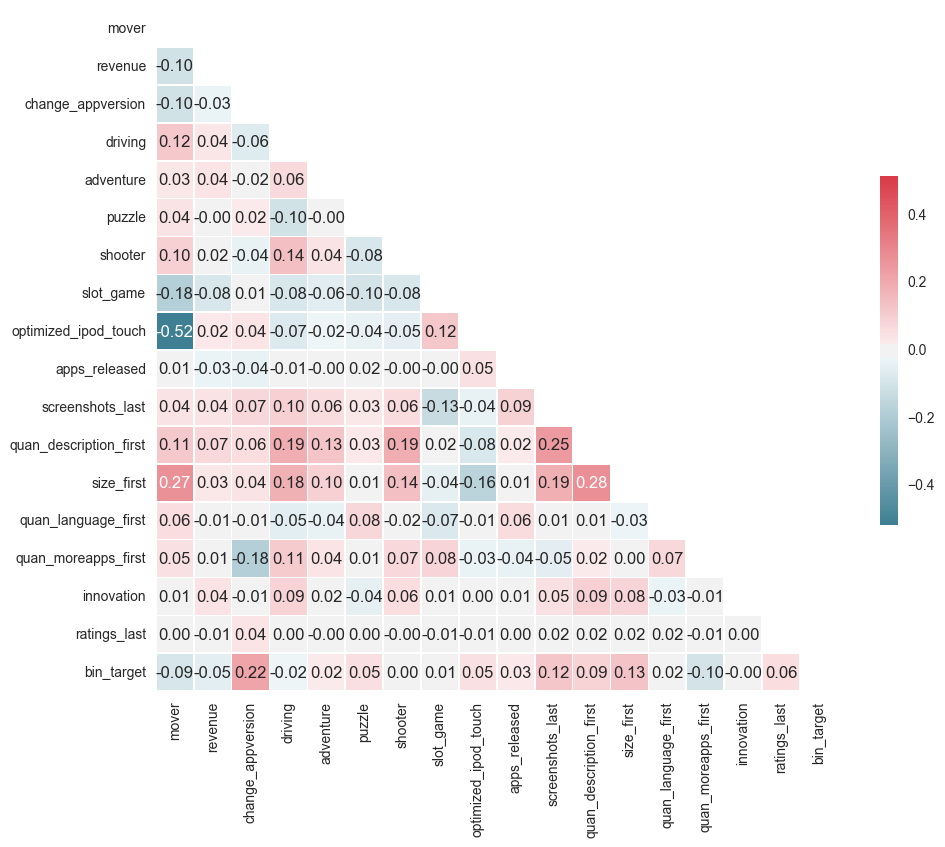

In [18]:
corr_df = result.copy()
corr_df['mover'] = pd.Categorical(corr_df['mover']).codes
corr_df['revenue'] = pd.Categorical(corr_df['revenue']).codes
show_correlation_matrix(corr_df)

### <a name="selectingmodel">5 Selecting Statistical Model</a> 
[Back to Table of Contents](#table)


The target that we are considering is the number of ratings for a particular app. This target can therefore been seen as a count variable. 

For count variables there are often two types of models that can be used; a Poisson model or a Negative Binomial model. Let's start with the Poisson model. 

The Poisson model assumes equidispersion which means that the conditional mean should be equal to the conditional variance. If the variance is higher than the mean than we can say that the dependent variable is overdispersed (Burger, Van Oort, & Linders, 2009). This is often a problem seeing as in many cases in the real word the variance is much higher than the mean (Atkins, Baldwin, Zheng, Gallop, & Neighbors, 2013). If we take our data set and extract the variance and mean we can clearly see that the ratio of variance to the mean (dispersion parameter) exceeds 1 (equidispersion). 

In [19]:
# Checking for dispersion
variance = round(np.var(result['ratings_last']))
mean = int(result['ratings_last'].describe()['mean'])
print('The Poisson model has strict assumptions. One that is often violated is that the mean equals the variance:')
print('Variance: \t\t  {}'.format(variance))
print('Mean:\t\t\t  {}'.format(mean))
print('Dispersion parameter:\t  {}'.format(round(variance/mean)))

The Poisson model has strict assumptions. One that is often violated is that the mean equals the variance:
Variance: 		  6792110
Mean:			  54
Dispersion parameter:	  125780


In [20]:
%%R -i result
model <- glm(ratings_last ~ mover * revenue, data=result, family=quasipoisson)
dispersion <- capture.output({summary(model)})

In [21]:
dispersion = %R dispersion
for line in dispersion[17:-6]:
    print(line)


(Dispersion parameter for quasipoisson family taken to be 108013.3)



We can clearly see that the mean doesn't equal the variance and that the dispersion is high. Thus, we need a different model that allows for failing this assumption. The Poisson model can be extended by a more general model which is the negative binomial model. This model allows the mean and varuance to be different. Basically, if the mean and variance were to be the same then Poisson and Negative Binomial would give the same results. However, seeing as that isn't the case, we are going forward with the negative binomial model. 

Although we now have chosen the correct model there's still the issue of a high number of zeros. You can see below that the number of zeros in the dataset is 7.56 times the number of non-zeros. 

In [22]:
zero = result['ratings_last'][result['ratings_last']==0].count()
not_zero = result['ratings_last'][result['ratings_last']!=0].count()
print('Number of zero ratings: \t\t\t{}'.format(zero))
print('Number of not zero ratings: \t\t\t{}'.format(not_zero))
print('Number of zero ratings compared to non-zero: \t{}'.format(round(float(zero/not_zero), 2)))

Number of zero ratings: 			20758
Number of not zero ratings: 			2747
Number of zero ratings compared to non-zero: 	7.56


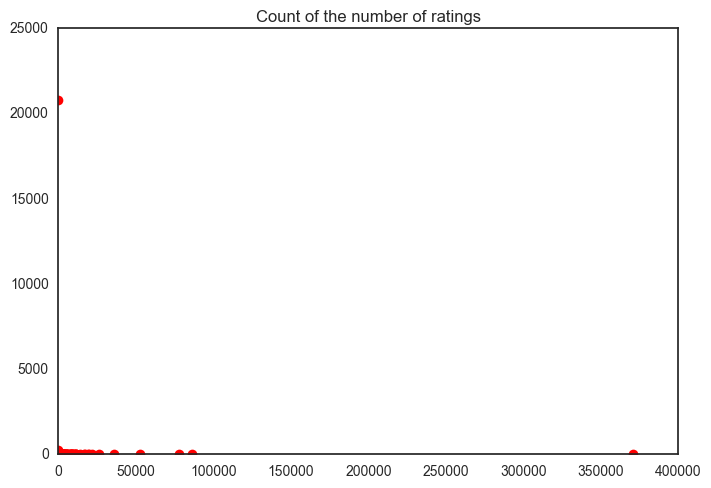

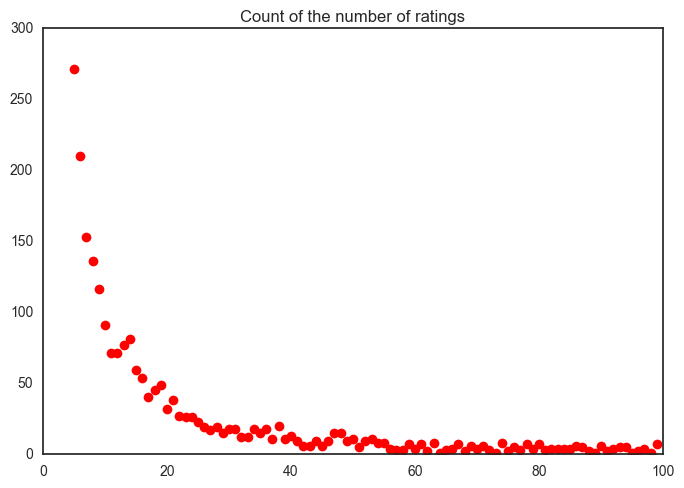

In [23]:
# Plot zoomed out
temp = pd.DataFrame(result['ratings_last'].value_counts())
temp = temp.reset_index()

plt.title('Count of the number of ratings')
plt.plot(temp['index'],temp['ratings_last'], 'ro')
plt.show()

# Plot zoomed in 
temp = pd.DataFrame(result['ratings_last'][(result['ratings_last'] != 0)].value_counts()).reset_index()
temp = temp[temp['index'] < 100]

plt.title('Count of the number of ratings')
plt.plot(temp['index'], temp['ratings_last'], 'ro')
plt.show()

Appearantly, we're now dealing with a large inflation of the number of zeros seeing as there is a clear stack of zeros in the data (Atkins et al., 2013). Thus, we need to look at zero-inflated models (Greene, 1994) or hurdle models that account for the number of zeros in the data.  

Both hurdle and zero-inflated models account for a large number of zeros, but both do this in a different manner. Hurdle models basically split the data in two parts: zeros and non-zeros. Then a model is used for zero vs. non-zero and a model is used for non-zero values. The interpretability of hurdle models are easier since it generalizes the problem to a zero vs. non-zero logistical model and the remaining non-zeros can be regressed using (I think) a zero-truncated model. Since we don't have repeated observation there is no correlation within individual apps and we don't have to look at mixed models. 

Moreover, the zero-inflated binomial regression measures two processes and in our case the zeros might come from the fact that a person downloaded the app and didn't like it enough to leave a rating or that a person didn't downloaded the app and therefore couldn't leave a rating. --> This is debatable and why I prefer to do the Hurdle Model. 



#### <a name="revenue">6. Statistical Analysis - Revenue Model</a> 
[Back to Table of Contents](#table)


Dependent Variable:  
        - Number of Ratings
Independent Variables:
        - Mover (Early vs. Late)
        - Revenue (Paid vs. Freemium)
        - Technological Innovation (Yes vs. No)


#### <a name="revenuemain">6.1 Main Effects</a> 
[Back to Table of Contents](#table)


In [24]:
%%R -i result
library(pscl)
library(MASS)


# Create and execute hurdle model
modelHurdle <- hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      revenue + mover,
                      dist    = "negbin",
                      data    = result)

output <- capture.output({summary(modelHurdle)})

In [25]:
# Print results
output = %R output

for line in output[2:-1]:
    print(line)

print(' ')

hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + 
    slot_game + content_rating + quan_description_first + size_first + 
    quan_language_first + quan_moreapps_first + revenue + mover, data = result, 
    dist = "negbin")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -0.47362  -0.14464  -0.11666  -0.09045 184.11382 

Count model coefficients (truncated negbin with log link):
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.963e+00  3.760e-01   7.879 3.29e-15 ***
driving                 3.292e-01  1.895e-01   1.737 0.082301 .  
adventure              -3.737e-01  1.589e-01  -2.351 0.018715 *  
puzzle                 -3.282e-01  1.441e-01  -2.277 0.022788 *  
shooter                -2.936e-01  2.057e-01  -1.427 0.153520    
slot_game              -2.807e+00  2.264e-01 -12.398  < 2e-16 ***
content_rating> 17      7.079e-01  3.395e-01   2.085 0.037037 *  
content_rating> 4      -8.673e-01  1.861e-

#### <a name="revenueinteraction">6.2 Interaction Effects</a> 
[Back to Table of Contents](#table)

In [26]:
%%R -i result
library(ggplot2)
library(pscl)
library(MASS)
library(boot)
library(glmmADMB)
library(pscl)

# Create and execute hurdle model
modelHurdle <- hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      revenue * mover,
                      dist    = "negbin",
                      data    = result)

# Comparing with ZINB
zinb <- zeroinfl(ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      revenue * mover,
  data = result, dist = "negbin")
aic <- AIC(modelHurdle, zinb)

output <- capture.output({summary(modelHurdle)})
aic <- capture.output({aic})

In [27]:
aic = %R aic

for line in aic:
    print(line)
print('')

            df      AIC
modelHurdle 33 45436.65
zinb        33 45398.22



In [28]:
# Print results
output = %R output

for line in output[2:-1]:
    print(line)

print(' ')

hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + 
    slot_game + content_rating + quan_description_first + size_first + 
    quan_language_first + quan_moreapps_first + revenue * mover, data = result, 
    dist = "negbin")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -0.53139  -0.14540  -0.11745  -0.09123 174.53878 

Count model coefficients (truncated negbin with log link):
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.891e+00  3.521e-01   8.211  < 2e-16 ***
driving                 3.360e-01  1.868e-01   1.799 0.072065 .  
adventure              -4.554e-01  1.572e-01  -2.898 0.003758 ** 
puzzle                 -3.292e-01  1.418e-01  -2.321 0.020301 *  
shooter                -2.475e-01  2.038e-01  -1.214 0.224704    
slot_game              -2.739e+00  2.216e-01 -12.359  < 2e-16 ***
content_rating> 17      5.706e-01  3.333e-01   1.712 0.086897 .  
content_rating> 4      -7.838e-01  1.825e-

In [29]:
print('N: {}'.format(len(result[(result['mover']=='late') & (result['innovation'] ==1)])))
print('Mean: {}'.format(result[(result['mover']=='late')& (result['innovation'] ==1)].ratings_last.mean()))
print('Std: {}\n'.format(np.std(result[(result['mover']=='late')& (result['innovation'] ==1)].ratings_last)))

N: 324
Mean: 7.074074074074074
Std: 56.139877725697545



#### <a name="revenuetruncated">6.3 Truncated Model</a> 
[Back to Table of Contents](#table)

In [30]:
to_plot = result[result['ratings_last']>0].groupby(by=['mover', 'revenue']).mean().reset_index()
to_plot['revenue_new'] = to_plot.apply(lambda row: 0 if row['revenue'] == 'Paid' else 1, axis = 1)

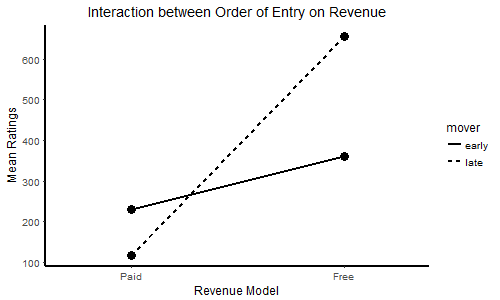

In [31]:
%%R -i to_plot -w 500 -h 300
library(ggplot2)

ggplot(to_plot, aes(x = revenue_new, y = ratings_last, group = mover, linetype = mover)) + geom_line(size =1) + geom_point(size = 4) +
theme_bw() + 
    theme(panel.border = element_blank(), 
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), 
          axis.line = element_line(colour = "black", size = 1, linetype = "solid"),
          text = element_text(size=12),
          plot.title = element_text(hjust = 0.5)) +
    labs(x = 'Revenue Model', 
         y ="Mean Ratings",
         title = "Interaction between Order of Entry on Revenue",
        color = 'Order of Entry') + 
        scale_x_continuous(breaks = round(seq(min(to_plot$revenue_new), max(to_plot$revenue_new), by = 1),1), 
                           expand = c(0.2, 0.2), labels = c('Paid', 'Free'))

#### <a name="revenuelogistical">6.4 Logistical Model</a> 
[Back to Table of Contents](#table)

In [32]:
to_plot = result.groupby(by=['mover', 'revenue']).mean().reset_index()
to_plot['revenue_new'] = to_plot.apply(lambda row: 0 if row['revenue'] == 'Paid' else 1, axis = 1)

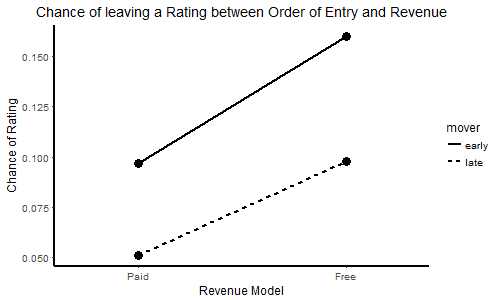

In [33]:
%%R -i to_plot -w 500 -h 300
library(ggplot2)

ggplot(to_plot, aes(x = revenue_new, y = bin_target ,group = mover, linetype = mover)) + geom_line(size =1) + geom_point(size = 4) +
theme_bw() + 
    theme(panel.border = element_blank(), 
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), 
          axis.line = element_line(colour = "black", size = 1, linetype = "solid"),
          text = element_text(size=12),
          plot.title = element_text(hjust = 0.5)) +
    labs(x = 'Revenue Model', 
         y ="Chance of Rating",
         title = "Chance of leaving a Rating between Order of Entry and Revenue",
        color = 'Order of Entry') + 
        scale_x_continuous(breaks = round(seq(min(to_plot$revenue_new), max(to_plot$revenue_new), by = 1),1), 
                           expand = c(0.2, 0.2), labels = c('Paid', 'Free'))

#### <a name="revenueresults">6.5 Results</a> 
[Back to Table of Contents](#table)

Seeing as there are 2 models used in the hurdle model we interpret the results seperately.  
  
**Logistical model**  
The chance of an user leaving a rating for late movers is significantly lower than that for early movers.   
In other words, users of late apps are 0.57 times less likely to leave a rating compared to early movers.   
  
The chance of an user leaving a rating for paid apps is significantly lower than that of users of free apps.   
In other words, users of paid apps are 0.56 times less likely to leave a rating compared to free apps.   
  
These was no interaction effect of revenue on mover.   
  
**Truncated negative binomial model**  
Later movers have significantly more ratings than early movers.  
Free apps get significantly more ratings than paid apps.   
  
Late movers have a higher number of ratings than early movers when it concerns free apps.  
This is reversed for paid apps, late movers get lower number of ratings than early movers.   
Thus, late movers have a higher number of ratings than early movers. This effect is reversed if it concerns paid apps and is strengthened if it concerns free apps.   


### <a name="ti">7. Statistical Analysis - Technological Innovation</a> 
[Back to Table of Contents](#table)

#### <a name="timain">7.1 Main Effects</a> 
[Back to Table of Contents](#table)

In [34]:
%%R -i result
library(pscl)


# Create and execute hurdle model
modelHurdle <- hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      innovation + mover,
                      dist    = "negbin",
                      data    = result)

# Export output
output <- capture.output({summary(modelHurdle)})

In [35]:
# Print results
output = %R output

for line in output[2:-1]:
    print(line)

print(' ')

hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + 
    slot_game + content_rating + quan_description_first + size_first + 
    quan_language_first + quan_moreapps_first + innovation + mover, data = result, 
    dist = "negbin")

Pearson residuals:
      Min        1Q    Median        3Q       Max 
 -0.45575  -0.14605  -0.12021  -0.09072 182.22818 

Count model coefficients (truncated negbin with log link):
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.828e+00  3.879e-01   7.289 3.13e-13 ***
driving                 3.237e-01  1.896e-01   1.707 0.087748 .  
adventure              -4.380e-01  1.562e-01  -2.804 0.005055 ** 
puzzle                 -3.120e-01  1.450e-01  -2.152 0.031362 *  
shooter                -2.758e-01  2.207e-01  -1.250 0.211404    
slot_game              -2.744e+00  2.307e-01 -11.894  < 2e-16 ***
content_rating> 17      6.439e-01  3.507e-01   1.836 0.066307 .  
content_rating> 4      -8.208e-01  1.93

#### <a name="tiinteraction">7.2 Interaction Effects</a> 
[Back to Table of Contents](#table)

In [37]:
%%R -i result
library(ggplot2)
library(pscl)
library(MASS)
library(boot)
library(glmmADMB)
library(pscl)

# Create and execute hurdle model
modelHurdle <- hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      innovation * mover,
                      dist    = "negbin",
                      data    = result)

# Comparing with ZINB
zinb <- zeroinfl(ratings_last ~ driving + adventure + puzzle + shooter + slot_game + content_rating +
                      quan_description_first + size_first + quan_language_first + quan_moreapps_first +                      
                      innovation * mover,
  data = result, dist = "negbin")
aic <- AIC(modelHurdle, zinb)

# Export output
output <- capture.output({summary(modelHurdle)})
aic <- capture.output({aic})

In [38]:
aic = %R aic

for line in aic:
    print(line)
print('')


            df      AIC
modelHurdle 33 45599.24
zinb        33 45577.37



In [39]:
# Print results
output = %R output
expCoef = %R expCoef

for line in output[2:-1]:
    print(line)

print(' ')

hurdle(formula = ratings_last ~ driving + adventure + puzzle + shooter + 
    slot_game + content_rating + quan_description_first + size_first + 
    quan_language_first + quan_moreapps_first + innovation * mover, data = result, 
    dist = "negbin")

Pearson residuals:
     Min       1Q   Median       3Q      Max 
 -0.4467  -0.1469  -0.1205  -0.0912 180.3122 

Count model coefficients (truncated negbin with log link):
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.849e+00  3.693e-01   7.712 1.24e-14 ***
driving                 3.360e-01  1.889e-01   1.779 0.075291 .  
adventure              -4.176e-01  1.561e-01  -2.674 0.007494 ** 
puzzle                 -3.103e-01  1.449e-01  -2.141 0.032255 *  
shooter                -3.554e-01  2.114e-01  -1.681 0.092792 .  
slot_game              -2.697e+00  2.279e-01 -11.833  < 2e-16 ***
content_rating> 17      6.763e-01  3.484e-01   1.941 0.052272 .  
content_rating> 4      -7.561e-01  1.890e-01  -4.

In [40]:
print('Mean Early entrants + TI: {}'.format(result[(result['mover']=='early') & (result['innovation']==1)].ratings_last.mean()))
print('Std Early entrants + TI: {}\n'.format(np.std(result[(result['mover']=='early') & (result['innovation']==1)].ratings_last)))

print('Mean Late entrants + TI: {}'.format(result[(result['mover']=='late') & (result['innovation']==1)].ratings_last.mean()))
print('Std Late entrants + TI: {}\n'.format(np.std(result[(result['mover']=='late') & (result['innovation']==1)].ratings_last)))


Mean Early entrants + TI: 142.2468085106383
Std Early entrants + TI: 1693.3583321947046

Mean Late entrants + TI: 7.074074074074074
Std Late entrants + TI: 56.139877725697545



In [41]:
print('Mean Early entrants + No TI: {}'.format(result[(result['mover']=='early') & (result['innovation']==0)].ratings_last.mean()))
print('Std Early entrants + No TI: {}\n'.format(np.std(result[(result['mover']=='early') & (result['innovation']==0)].ratings_last)))

print('Mean Late entrants + No TI: {}'.format(result[(result['mover']=='late') & (result['innovation']==0)].ratings_last.mean()))
print('Std Late entrants + No TI: {}\n'.format(np.std(result[(result['mover']=='late') & (result['innovation']==0)].ratings_last)))


Mean Early entrants + No TI: 48.52133436772692
Std Early entrants + No TI: 1323.35594862746

Mean Late entrants + No TI: 58.20294443564983
Std Late entrants + No TI: 3339.6638124301403



#### <a name="titruncated">7.3 Truncated Model</a> 
[Back to Table of Contents](#table)

In [42]:
to_plot = result[result['ratings_last']>0].groupby(by=['mover', 'innovation']).mean().reset_index()

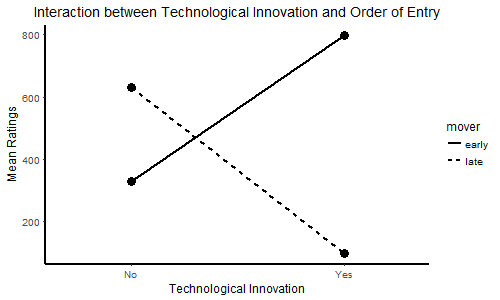

In [43]:
%%R -i to_plot -w 500 -h 300
library(ggplot2)

ggplot(to_plot, aes(x = innovation, y = ratings_last ,group = mover, linetype = mover)) + geom_line(size =1) + geom_point(size = 4) +
theme_bw() + 
    theme(panel.border = element_blank(), 
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), 
          axis.line = element_line(colour = "black", size = 1, linetype = "solid"),
          text = element_text(size=12),
          plot.title = element_text(hjust = 0.5)) +
    labs(x = 'Technological Innovation', 
         y ="Mean Ratings",
         title = "Interaction between Technological Innovation and Order of Entry",
        color = 'Order of Entry') + 
        scale_x_continuous(breaks = round(seq(min(to_plot$innovation), max(to_plot$innovation), by = 1),1), 
                           expand = c(0.2, 0.2), labels = c('No', 'Yes'))

#### <a name="tilogistical">7.4 Logistical Model</a> 
[Back to Table of Contents](#table)

In [44]:
to_plot = result.groupby(by=['mover', 'innovation']).mean().reset_index()

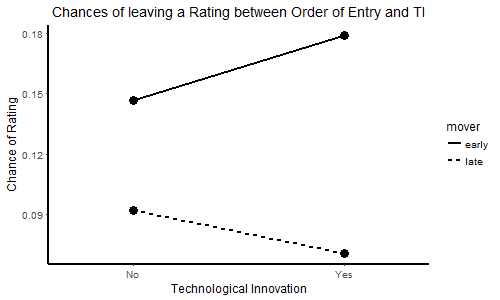

In [45]:
%%R -i to_plot -w 500 -h 300
library(ggplot2)

ggplot(to_plot, aes(x = innovation, y = bin_target ,group = mover , linetype = mover)) + geom_line(size =1) + geom_point(size = 4) +
theme_bw() + 
    theme(panel.border = element_blank(), 
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(), 
          axis.line = element_line(colour = "black", size = 1, linetype = "solid"),
          text = element_text(size=12),
          plot.title = element_text(hjust = 0.5)) +
    labs(x = 'Technological Innovation', 
         y ="Chance of Rating",
         title = "Chances of leaving a Rating between Order of Entry and TI",
        color = 'Order of Entry') + 
        scale_x_continuous(breaks = round(seq(min(to_plot$innovation), max(to_plot$innovation), by = 1),1), 
                           expand = c(0.2, 0.2), labels = c('No', 'Yes'))

#### <a name="tiresults">7.5 Results</a> 
[Back to Table of Contents](#table)

Seeing as there are 2 models used in the hurdle model we interpret the results seperately.  
  
**Logistical model**  
The logistical model showed that the chance of an user leaving a rating for late entrants is significantly lower than that for early entrants (p < .001). 

Moreover, there was no significant difference in the chance of getting ratings between apps using
technological innovation and not using technological innovation (p = .081). 

There was an interaction effect of technological innovation on order of entry (p = .131, R2 = .05). 
  
**Truncated negative binomial model**  
The truncated negative binomial model showed that later entrants have on
average significantly more ratings than early entrants (p < .001). 

Moreover, there was no significant difference between the number of ratings for apps making use of
technological innovation and apps not making use of technological innovation (p = .720). 

Finally, an interaction was found between technological innovation and order of
entry. On average the number of ratings for early entrants making use of technological
innovation are higher than the number of ratings for later entrants making use of
technological innovation, whereas the number of ratings for later entrants not making
use of technological innovation were on average higher than the number of ratings for
early entrants not making use of technological innovation (p < .001, R2 = .33).

### <a name="conclusion">8. Conclusion</a> 
[Back to Table of Contents](#table)

The results showed that both revenue model and technological innovation
moderate the effect between order of entry and the performance of mobile games.
However, the hurdle of being the first user to rate an unrated app might decrease the
moderating effects of both revenue model and technological innovation. When
launching a mobile game, app developers need to take into account their order for entry
into account. Knowing if you are an early or late entrant helps selecting the appropriate
revenue model and whether the app would benefit from technological innovation.

### <a name="literature">9. References</a> 
[Back to Table of Contents](#table)

Atkins, D. C., Baldwin, S. A., Zheng, C., Gallop, R. J., & Neighbors, C. (2013). A tutorial on count regression and zero-altered count models for longitudinal substance use data. Psychology of Addictive Behaviors, 27(1), 166.
  
Burger, M., Van Oort, F., & Linders, G. J. (2009). On the specification of the gravity model of trade: zeros, excess zeros and zero-inflated estimation. Spatial Economic Analysis, 4(2), 167-190.

Greene, W. H. (1994). Accounting for excess zeros and sample selection in Poisson and negative binomial regression models.